In [16]:
# Access voter_data from 
%store -r voter_data

In [17]:
voter_data

,Voters_VotingPerformanceEvenYearGeneral_%,CommercialData_EstimatedHHIncomeAmount_$,CommercialData_EstHomeValue_$,County,Ethnic_Description,Voters_Gender,income_bracket
0,50.0,47000.0,253332.0,ALBANY,Irish,M,25k-50k
1,14.0,46718.0,177015.0,ALBANY,English/Welsh,M,25k-50k
2,100.0,85000.0,242247.0,ALBANY,Dutch (Netherlands),Unknown,75k-100k
3,100.0,6000.0,287499.0,ALBANY,Irish,F,0-25k
4,33.0,20832.0,287499.0,ALBANY,English/Welsh,M,0-25k
...,...,...,...,...,...,...,...
290403,0.0,61764.0,104629.0,WESTON,English/Welsh,M,50k-75k
290404,33.0,7000.0,53724.0,WESTON,German,F,0-25k
290405,85.0,9000.0,101065.0,WESTON,Unknown,F,0-25k
290406,66.0,61764.0,87500.0,WESTON,English/Welsh,M,50k-75k


In [18]:
corr_matrix = voter_data.corr()
corr_matrix

,Voters_VotingPerformanceEvenYearGeneral_%,CommercialData_EstimatedHHIncomeAmount_$,CommercialData_EstHomeValue_$
Voters_VotingPerformanceEvenYearGeneral_%,1.000000,0.013207,0.036226
CommercialData_EstimatedHHIncomeAmount_$,0.013207,1.000000,0.321263
CommercialData_EstHomeValue_$,0.036226,0.321263,1.000000


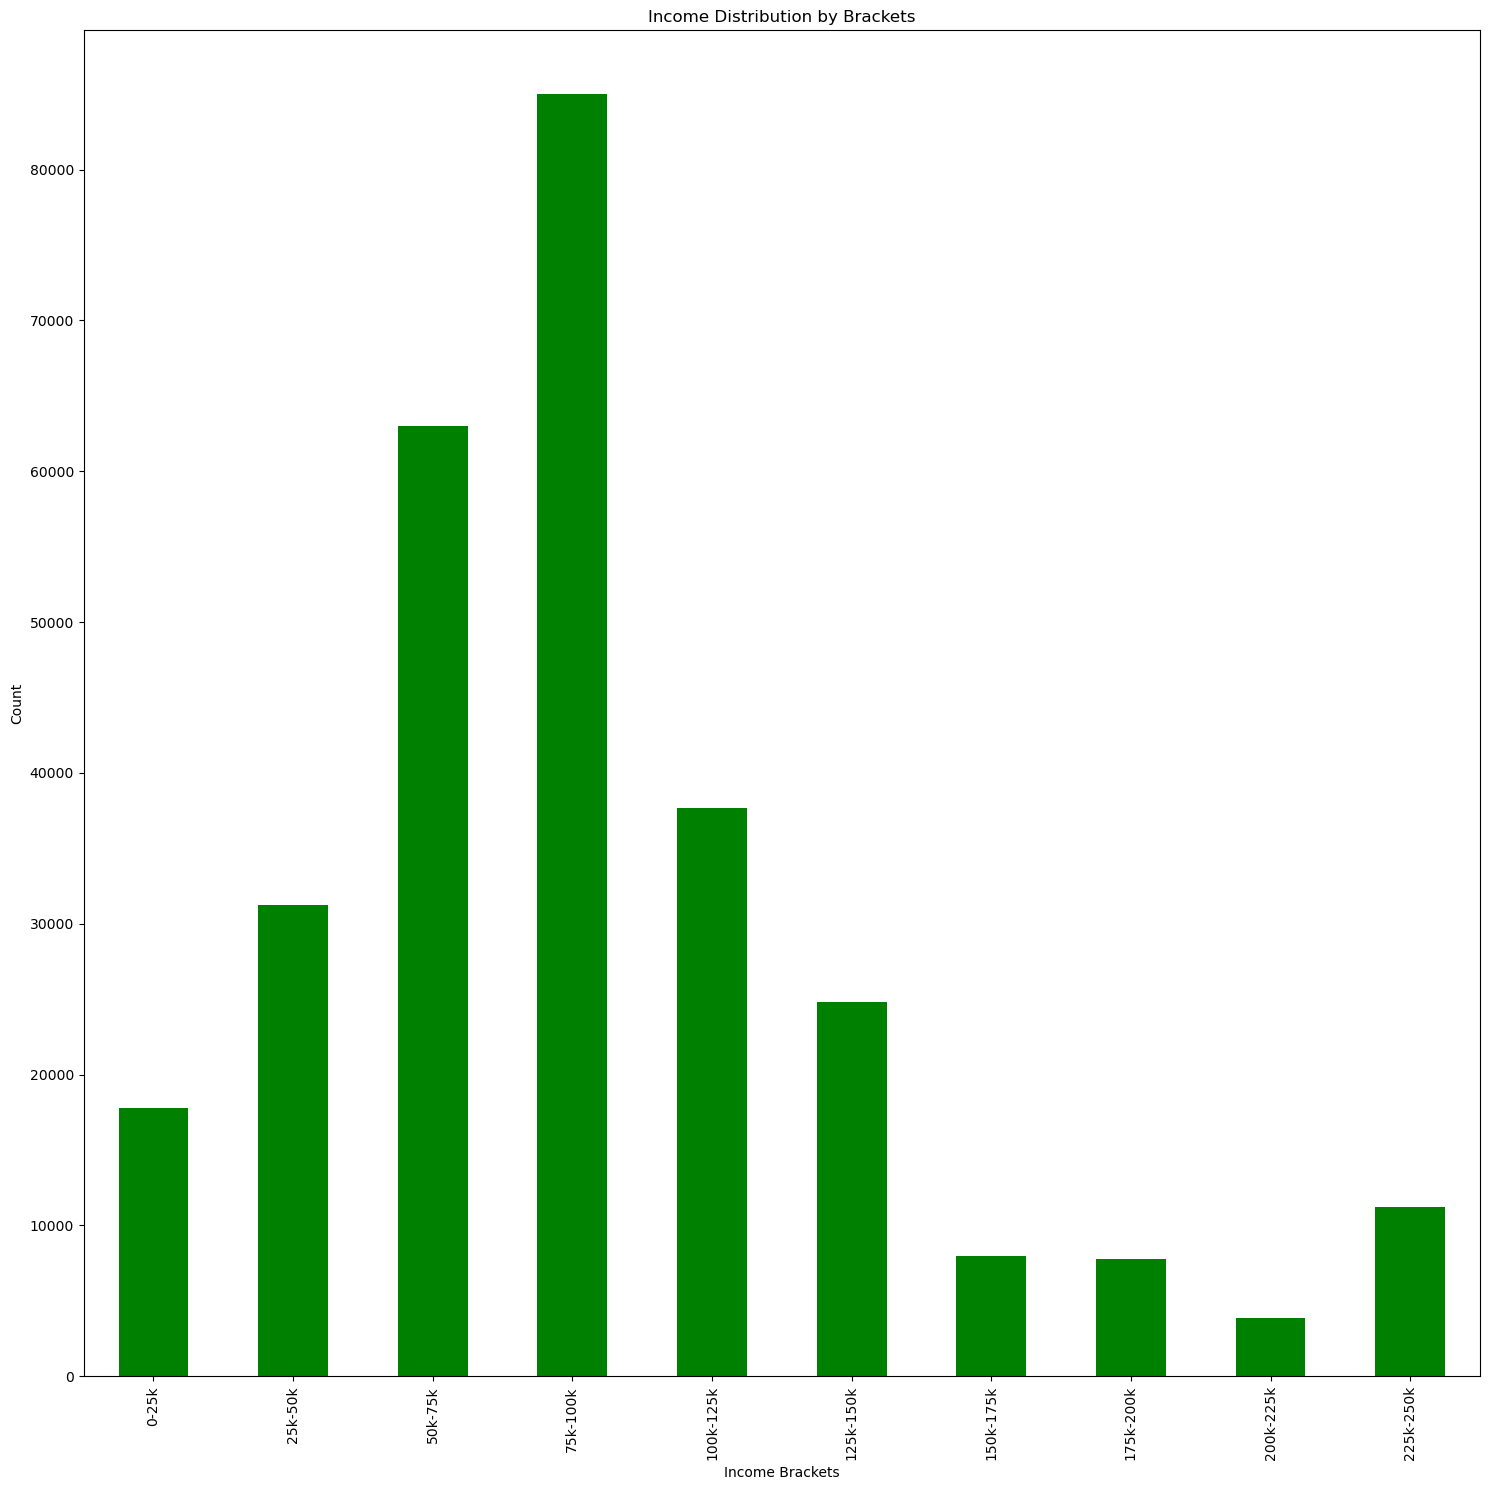

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

bins = [0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000]
labels = ['0-25k', '25k-50k', '50k-75k', '75k-100k', '100k-125k', '125k-150k', '150k-175k', '175k-200k', '200k-225k', '225k-250k']

#new column for income bracket 
voter_data['income_bracket'] = pd.cut(voter_data['CommercialData_EstimatedHHIncomeAmount_$'], bins=bins, labels=labels)

#number of occurences
income_bracket_count = voter_data['income_bracket'].value_counts(sort=False)

#distribution of income brackets
plt.figure(figsize=(15, 15))
income_bracket_count.plot(kind='bar', color='green')
plt.title('Income Distribution by Brackets')
plt.xlabel('Income Brackets')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [20]:
grouped_income_df = voter_data.groupby('income_bracket')['Voters_VotingPerformanceEvenYearGeneral_%'].mean().reset_index()
grouped_income_df = grouped_income_df.sort_values(by='Voters_VotingPerformanceEvenYearGeneral_%', ascending=False)

grouped_income_df

,income_bracket,Voters_VotingPerformanceEvenYearGeneral_%
9,225k-250k,88.249289
1,25k-50k,87.170832
7,175k-200k,86.875818
6,150k-175k,86.734802
8,200k-225k,86.221964
0,0-25k,86.209456
4,100k-125k,86.118798
5,125k-150k,85.798583
2,50k-75k,85.513491
3,75k-100k,85.385469


In [ ]:
plt.figure(figsize=(15, 15))
plt.bar(voter_data["income_bracket"], voter_data["Voters_VotingPerformanceEvenYearGeneral_%"], color='green')
plt.show()

In [21]:
#pyspark

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Imputer
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("K-Means Clustering") \
    .getOrCreate()

# Handling Numerical Features
numeric_features = ['Voters_VotingPerformanceEvenYearGeneral', 'CommercialData_EstimatedHHIncomeAmount', 'CommercialData_EstHomeValue']
imputer = Imputer(inputCols=numeric_features, outputCols=numeric_features, strategy="median")
numeric_assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features_vector")
scaler = StandardScaler(inputCol="numeric_features_vector", outputCol="scaled_numeric_features")

# Handling Categorical Features
categorical_features = ['County', 'Ethnic_Description', 'Voters_Gender']
indexers = [StringIndexer(inputCol=column, outputCol="{0}_indexed".format(column)) for column in categorical_features]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
                        outputCols=["{0}_encoded".format(indexer.getInputCol()) for indexer in indexers])

# Combine processed numerical and categorical features into a single vector
assembler = VectorAssembler(inputCols=encoder.getOutputCols() + ["scaled_numeric_features"], outputCol="features")

# K-Means Clustering
kmeans = KMeans(featuresCol="features", k=3, seed=42)  # Seed for reproducibility

# Pipeline
pipeline = Pipeline(stages=[imputer, numeric_assembler, scaler] + indexers + [encoder, assembler, kmeans])

# Fit the model and make predictions
model = pipeline.fit(voter_data)
predictions = model.transform(voter_data)

# Show the results
predictions.select("prediction").show()


AttributeError: 'DataFrame' object has no attribute '_jdf'

In [ ]:
#pyspark 

from pyspark.ml.feature import PCA as PCAPyspark
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

# Apply PCA to reduce the features to 2 components
pca = PCAPyspark(inputCol="features", outputCol="pcaFeatures", k=2)
pcaModel = pca.fit(predictions)
pcaResult = pcaModel.transform(predictions)

# Select the PCA features and the cluster predictions
pcaAndCluster = pcaResult.select(col("pcaFeatures"), col("Cluster"))

# Convert to a Pandas DataFrame for plotting
pandasDF = pcaAndCluster.toPandas()

# Extract the PCA features from the 'pcaFeatures' column
pandasDF['PC1'] = pandasDF['pcaFeatures'].apply(lambda x: x[0])
pandasDF['PC2'] = pandasDF['pcaFeatures'].apply(lambda x: x[1])

In [ ]:
import matplotlib.pyplot as plt

#converted Pandas DataFrame for plotting
plt.figure(figsize=(10, 7))
plt.scatter(pandasDF['PC1'], pandasDF['PC2'], c=pandasDF['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
#ignore this cell & below 

#k-means clustering model 

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

numeric_features = ['Voters_VotingPerformanceEvenYearGeneral', 'CommercialData_EstimatedHHIncomeAmount', 'CommercialData_EstHomeValue']
categorical_features = ['County', 'Ethnic_Description', 'Voters_Gender']

#preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:


#K-means clustering pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clusterer', KMeans(n_clusters=3, random_state=42))])

#apply pipeline to predict clusters
pipeline.fit(voter_data)

clusters = pipeline.predict(voter_data)

voter_data['Cluster'] = clusters


In [ ]:
#pandas 

#visualizing with PCA 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

preprocessed_data = pipeline.named_steps['preprocessor'].transform(voter_data)
clusters = pipeline.named_steps['clusterer'].labels_

#apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(preprocessed_data)

#plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
